# Import

In [1]:
import numpy as np
import os
import cv2
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform, AffineTransform

# Suppress the specific warning
import csv
from datetime import datetime
from tqdm import tqdm

import torch
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data

from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from utils.utils0 import *
from utils.utils1 import *
from utils.utils1 import ModelParams, DL_affine_plot, loss_extra

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

# Stub to warn about opencv version.
if int(cv2.__version__[0]) < 3: # pragma: no cover
  print('Warning: OpenCV 3 is not installed')

image_size = 256


Device: cuda


## Cases, model parameters
- Supervised DL w/ groundtruth affine transformation parameters (MSE params, MSE, NCC images)
    - Synthetic eye
    - Synthetic shape
- Unsupervised DL (MSE, NCC images)
    - Actual eye data
    - Synthetic eye
    - Synthetic shape
- Data
    - only images
    - only heatmaps
    - images & heatmaps
- Loss function
    - MSE affine parameters
    - MSE, NCC images

    

In [2]:
model_params = ModelParams(sup=1, dataset=1, image=1, heatmaps=0, 
                           loss_image=2, num_epochs=2)
model_params.print_explanation()

Model name:  dataset1_sup1_image1_heatmaps0_loss_image2
Model code:  11102_0.001_0_2_1
Model params:  {'dataset': 1, 'sup': 1, 'image': 1, 'heatmaps': 0, 'loss_image_case': 2, 'loss_image': <utils.utils1.MSE_SSIM object at 0x7fc38839d430>, 'loss_affine': <utils.utils1.loss_affine object at 0x7fc38839d160>, 'learning_rate': 0.001, 'decay_rate': 0.96, 'start_epoch': 0, 'num_epochs': 2, 'batch_size': 1, 'model_name': 'dataset1_sup1_image1_heatmaps0_loss_image2'}

Model name:  dataset1_sup1_image1_heatmaps0_loss_image2
Model code:  11102_0.001_0_2_1
Dataset used:  Synthetic eye
Supervised or unsupervised model:  Supervised
Image type:  Image used
Heatmaps used:  Heatmaps not used
Loss function case:  2
Loss function for image:  <utils.utils1.MSE_SSIM object at 0x7fc38839d430>
Loss function for affine:  <utils.utils1.loss_affine object at 0x7fc38839d160>
Learning rate:  0.001
Decay rate:  0.96
Start epoch:  0
Number of epochs:  2
Batch size:  1




# Models
## SuperPoint

In [3]:
from utils.SuperPoint import SuperPointFrontend

## ImgReg Network

In [4]:
from utils.SPaffineNet import SP_AffineNet

## SP ImgReg model

In [5]:
# dx = 2.0
# dy = 3.0
# translation_matrix = torch.tensor([[1.0, 0.0, dx],
#                                   [0.0, 1.0, dy]])
# print(translation_matrix.shape)

# x = torch.tensor([1.0, 2.0, 3.0])
# y = torch.tensor([4.0, 5.0, 6.0])

# # Combine x and y into a (2, N) tensor
# points = torch.stack((x, y), dim=0)

# ones = torch.ones(points.shape[1]).unsqueeze(0)
# print(ones.shape)

# points = torch.cat((points, ones), dim=0)
# print(points.shape)

# # Apply the transformation
# transformed_points = torch.mm(translation_matrix, points)
# transformed_points

In [6]:
# def transform_points(points, affine_params):
#     affine_params = affine_params.double()
#     # Convert points to tensor
#     points = torch.tensor(points).double().to(affine_params.device)
#     # reshape points tensor to (2, N) shape
#     points = points.reshape(2, -1)


#     # Add row of ones to points tensor
#     ones = torch.ones(points.shape[1], device=points.device).unsqueeze(0)
#     points = torch.cat((points, ones), dim=0)

#     # Apply affine transformation
#     transformed_points = torch.mm(affine_params.squeeze(0), points)

#     # Remove last row of ones
#     # transformed_points = transformed_points[:2, :]
#     # print('transformed_points: ', transformed_points.shape)

#     return transformed_points

# # define model
# class SP_AffineNet(nn.Module):
#     def __init__(self):
#         super(SP_AffineNet, self).__init__()
#         self.superpoint = SuperPointFrontend('utils/superpoint_v1.pth', nms_dist=4,
#                           conf_thresh=0.015, nn_thresh=0.7, cuda=True)
#         self.affineNet = AffineNet()
#         self.nn_thresh = 0.7

#     def forward(self, source_image, target_image):
#         # source_image = source_image.to(device)
#         # target_image = target_image.to(device)

#         # print('source_image: ', source_image.shape)
#         # print('target_image: ', target_image.shape)
#         points1, desc1, heatmap1 = self.superpoint(source_image[0, 0, :, :].cpu().numpy())
#         points2, desc2, heatmap2 = self.superpoint(target_image[0, 0, :, :].cpu().numpy())

#         if model_params.heatmaps == 0:
#             affine_params = self.affineNet(source_image, target_image)
#         elif model_params.heatmaps == 1:
#             affine_params = self.affineNet(source_image, target_image, heatmap1, heatmap2)

#         # transform the source image using the affine parameters
#         # using F.affine_grid and F.grid_sample
#         transformed_source_affine = tensor_affine_transform(source_image, affine_params)

#         # match the points between the two images
#         tracker = PointTracker(5, nn_thresh=0.7)
#         try:
#             matches = tracker.nn_match_two_way(desc1, desc2, nn_thresh=self.nn_thresh)
#         except:
#             print('No matches found')
#             # TODO: find a better way to do this
#             try:
#                 while matches.shape[1] < 3 and self.nn_thresh > 0.1:
#                     self.nn_thresh = self.nn_thresh - 0.1
#                     matches = tracker.nn_match_two_way(desc1, desc2, nn_thresh=self.nn_thresh)
#             except:
#                 return transformed_source_affine, affine_params, [], [], [], [], [], [], []

#         # take the elements from points1 and points2 using the matches as indices
#         matches1 = points1[:2, matches[0, :].astype(int)]
#         matches2 = points2[:2, matches[1, :].astype(int)]

#         # transform the points using the affine parameters
#         matches1_transformed = transform_points(matches1.T[None, :, :], affine_params.cpu().detach())
#         return transformed_source_affine, affine_params, matches1, matches2, matches1_transformed, desc1, desc2, heatmap1, heatmap2

#         # return transformed_source_affine, affine_params


# Load data

In [7]:
from utils.datagen import datagen

In [8]:
# test datagen for all datasets and training and testing
for dataset in range(2): # don't forget to change this back to 2
    for is_train in [True, False]:
        for sup in [False, True]:
            print(f'dataset: {dataset}, is_train: {is_train}, sup: {sup}')
            dataloader = datagen(dataset, is_train, sup)
            
            if sup==1 and dataset==0:
                print('skipping')
                pass
            else:
                try:
                    print('index, source_img.shape,       target_img.shape')
                    for i, (source_img, target_img) in enumerate(dataloader):
                        print(i, source_img.shape, target_img.shape)
                        if i == 2:
                            break
                except ValueError:
                    print('index, source_img.shape,       target_img.shape,            affine_params.shape')
                    for i, batch in enumerate(dataloader):
                        print(i, batch[0].shape, batch[1].shape, batch[2].shape)
                        if i == 5:
                            break
            print('\n')

dataset: 0, is_train: True, sup: False
Training eye dataset
Number of training data:  500
index, source_img.shape,       target_img.shape
0 torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
1 torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
2 torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


dataset: 0, is_train: True, sup: True
Training eye dataset
Number of training data:  500
skipping


dataset: 0, is_train: False, sup: False
Test eye dataset
Number of testing data:  100
index, source_img.shape,       target_img.shape
0 torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
1 torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
2 torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


dataset: 0, is_train: False, sup: True
Test eye dataset
Number of testing data:  100
skipping


dataset: 1, is_train: True, sup: False
index, source_img.shape,       target_img.shape
0 torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
1 torch.Size([1, 1, 2

# Training
## Dataset initialization

In [9]:
train_dataset = datagen(model_params.dataset, True, model_params.sup)
test_dataset = datagen(model_params.dataset, False, model_params.sup)

# Get sample batch
print('Train set: ', [x.shape for x in next(iter(train_dataset))])
print('Test set: ', [x.shape for x in next(iter(test_dataset))])

Train set:  [torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]), torch.Size([1, 6])]
Test set:  [torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]), torch.Size([1, 6])]


## Model initialize

In [10]:
# print case
print(model_params)
model_params.print_explanation()

dataset1_sup1_image1_heatmaps0_loss_image2

Model name:  dataset1_sup1_image1_heatmaps0_loss_image2
Model code:  11102_0.001_0_2_1
Dataset used:  Synthetic eye
Supervised or unsupervised model:  Supervised
Image type:  Image used
Heatmaps used:  Heatmaps not used
Loss function case:  2
Loss function for image:  <utils.utils1.MSE_SSIM object at 0x7fc38839d430>
Loss function for affine:  <utils.utils1.loss_affine object at 0x7fc38839d160>
Learning rate:  0.001
Decay rate:  0.96
Start epoch:  0
Number of epochs:  2
Batch size:  1




In [14]:
model = SP_AffineNet(model_params).to(device)
print(model)

parameters = model.parameters()
optimizer = optim.Adam(parameters, model_params.learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: model_params.decay_rate ** epoch)
model_path = 'trained_models/10102_0.001_0_20_1_20230930-091532.pth'

# if a model is loaded, the training will continue from the epoch it was saved at
try:
    model.load_state_dict(torch.load(model_path))
    model_params.start_epoch = int(model_path.split('/')[-1].split('_')[3])
    print(f'Loaded model from {model_path}\nstarting at epoch {model_params.start_epoch}')
except:
    model_params.start_epoch = 0
    print('No model loaded, starting from scratch')


Running new version (not run SP on source image)
SP_AffineNet(
  (affineNet): AffineNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1s): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (conv2s): Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
    (conv3s): Conv2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
    (conv4s): Conv2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
    (fc1): Linear(in_features=1024, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=6, bias=Tr

## Training function

In [ ]:
# Define training function
def train(model, model_params, timestamp):
    # Define loss function based on supervised or unsupervised learning
    criterion = model_params.loss_image
    # extra = loss_extra()

    if model_params.sup:
        criterion_affine = nn.MSELoss()
        # TODO: add loss for points1_affine and points2, Euclidean distance

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=model_params.learning_rate)

    # Create empty list to store epoch number, train loss and validation loss
    epoch_loss_list = []
    
    # Create output directory
    output_dir = f"output/{model_params.get_model_code()}_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)

    # Train model
    for epoch in range(model_params.start_epoch, model_params.num_epochs):
        # Set model to training mode
        model.train()

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        running_loss = 0.0
        train_bar = tqdm(train_dataset, desc=f'Training Epoch {epoch+1}/{model_params.num_epochs}')
        for i, data in enumerate(train_bar):
            # Get images and affine parameters
            if model_params.sup:
                source_image, target_image, affine_params_true = data
            else:
                source_image, target_image = data
            source_image = source_image.to(device)
            target_image = target_image.to(device)

            # Forward + backward + optimize
            outputs = model(source_image, target_image)
            # for i in range(len(outputs)):
            #         print(i, outputs[i].shape)
            # 0 torch.Size([1, 1, 256, 256])
            # 1 torch.Size([1, 2, 3])
            # 2 (2, 4)
            # 3 (2, 4)
            # 4 (1, 4, 2)
            # 5 (256, 9)
            # 6 (256, 16)
            # 7 (256, 256)
            # 8 (256, 256)
            transformed_source_affine = outputs[0] # image
            affine_params_predicted = outputs[1] # affine parameters
            points1 = outputs[2]
            points2 = outputs[3]
            points1_affine = np.array(outputs[4])

            # print(f"affine_params_true: {affine_params_true}")
            # print(f"affine_params_predicted: {affine_params_predicted}\n")

            try:
                points1_affine = points1_affine.reshape(points1_affine.shape[2], points1_affine.shape[1])
            except:
                pass
            desc1 = outputs[5]
            desc2 = outputs[6]
            heatmap1 = outputs[7]
            heatmap2 = outputs[8]

            loss = criterion(transformed_source_affine, target_image)
            # loss += extra(affine_params_predicted)
            if model_params.sup:
                loss_affine = criterion_affine(affine_params_true.view(1, 2, 3), affine_params_predicted.cpu())
                # TODO: add loss for points1_affine and points2, Euclidean distance
                # loss_points = criterion_points(points1_affine, points2)

                loss += loss_affine
            loss.backward()
            optimizer.step()
            
            # Plot images if i < 5
            if i < 5:
                DL_affine_plot(f"epoch{epoch+1}_train", output_dir,
                    f"{i}", "_", source_image[0, 0, :, :].detach().cpu().numpy(), 
                    target_image[0, 0, :, :].detach().cpu().numpy(), 
                    transformed_source_affine[0, 0, :, :].detach().cpu().numpy(),
                    points1, points2, points1_affine, desc1, desc2, 
                    affine_params=affine_params_predicted, heatmap1=heatmap1, heatmap2=heatmap2, plot=True)

            # Print statistics
            running_loss += loss.item()
            train_bar.set_postfix({'loss': running_loss / (i+1)})
        print(f'Training Epoch {epoch+1}/{model_params.num_epochs} loss: {running_loss / len(train_dataset)}')

        scheduler.step()

        # Validate model
        validation_loss = 0.0
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataset, 0):
                # Get images and affine parameters
                if model_params.sup:
                    source_image, target_image, affine_params_true = data
                else:
                    source_image, target_image = data
                source_image = source_image.to(device)
                target_image = target_image.to(device)

                # Forward pass
                outputs = model(source_image, target_image)
                # for i in range(len(outputs)):
                #     print(i, outputs[i].shape)
                transformed_source_affine = outputs[0]
                affine_params_predicted = outputs[1]
                points1 = outputs[2]
                points2 = outputs[3]
                points1_affine = np.array(outputs[4])
                try:
                    points1_affine = points1_affine.reshape(points1_affine.shape[2], points1_affine.shape[1])
                except:
                    pass
                desc1 = outputs[5]
                desc2 = outputs[6]
                heatmap1 = outputs[7]
                heatmap2 = outputs[8]

                loss = criterion(transformed_source_affine, target_image)
                # loss += extra(affine_params_predicted)
                if model_params.sup:
                    loss_affine = criterion_affine(affine_params_true.view(1, 2, 3), affine_params_predicted.cpu())
                    # TODO: add loss for points1_affine and points2, Euclidean distance
                    # loss_points = criterion_points(points1_affine, points2)
                    loss += loss_affine

                # Add to validation loss
                validation_loss += loss.item()

                # Plot images if i < 5
                if i < 5:
                    DL_affine_plot(f"epoch{epoch+1}_valid", output_dir,
                        f"{i}", "_", source_image[0, 0, :, :].cpu().numpy(), target_image[0, 0, :, :].cpu().numpy(), \
                        transformed_source_affine[0, 0, :, :].cpu().numpy(),
                        points1, points2, points1_affine, desc1, desc2, \
                        affine_params=affine_params_predicted, heatmap1=heatmap1, heatmap2=heatmap2, plot=True)

        # Print validation statistics
        validation_loss /= len(test_dataset)
        print(f'Validation Epoch {epoch+1}/{model_params.num_epochs} loss: {validation_loss}')

        # Append epoch number, train loss and validation loss to epoch_loss_list
        epoch_loss_list.append([epoch+1, running_loss / len(train_dataset), validation_loss])

    print('Finished Training')

    # delete all txt files in output_dir
    for file in os.listdir(output_dir):
        if file.endswith(".txt"):
            os.remove(os.path.join(output_dir, file))

    # Extract epoch number, train loss and validation loss from epoch_loss_list
    epoch = [x[0] for x in epoch_loss_list]
    train_loss = [x[1] for x in epoch_loss_list]
    val_loss = [x[2] for x in epoch_loss_list]

    save_plot_name = f"{output_dir}/loss_{model_params.get_model_code()}_epoch{model_params.num_epochs}_{timestamp}.png"

    # Plot train loss and validation loss against epoch number
    plt.plot(epoch, train_loss, label='Train Loss')
    plt.plot(epoch, val_loss, label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    plt.savefig(save_plot_name)
    # plt.show()

    # Return epoch_loss_list
    return epoch_loss_list


## working code

Training Epoch 1/2: 100%|██████████| 920/920 [02:45<00:00,  5.56it/s, loss=1.11e+7]
/home/pkhamchuai/miniconda3/envs/spppt/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Training Epoch 1/2 loss: 11135864.591112332
Validation Epoch 1/2 loss: 16743949.926267281


Training Epoch 2/2: 100%|██████████| 920/920 [02:34<00:00,  5.97it/s, loss=9.37e+7]


Training Epoch 2/2 loss: 93668476.02814199
Validation Epoch 2/2 loss: 224074614.41474655
Finished Training


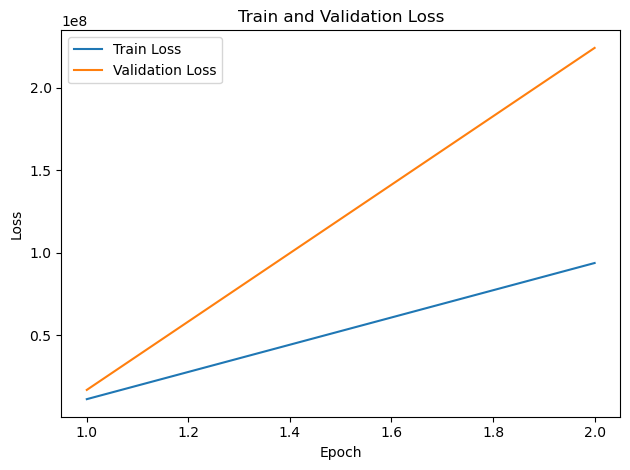

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
loss_list = train(model, model_params, timestamp)

In [ ]:
print("Training output:")
for i in range(len(loss_list)):
    print(loss_list[i])

Training output:
[1, 11135864.591112332, 16743949.926267281]
[2, 93668476.02814199, 224074614.41474655]


## Model saving

In [ ]:
model_save_path = "trained_models/"
model_name_to_save = model_save_path + f"{model_params.get_model_code()}_{timestamp}.pth"
print(model_name_to_save)
torch.save(model.state_dict(), model_name_to_save)


trained_models/11102_0.001_0_2_1_20231009-150043.pth


# Test model (loading and inference)

Save results and export metrics to csv

In [ ]:
model = SPmodel = SP_AffineNet().to(device)
print(model)

parameters = model.parameters()
optimizer = optim.Adam(parameters, model_params.learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: model_params.decay_rate ** epoch)

model.load_state_dict(torch.load(model_name_to_save))

SP_AffineNet(
  (affineNet): AffineNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1s): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (conv2s): Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
    (conv3s): Conv2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
    (conv4s): Conv2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
    (fc1): Linear(in_features=1024, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=6, bias=True)
    (aPooling): AdaptiveAvgPool2d(output_size=

<All keys matched successfully>

In [ ]:
def test(model, model_params, timestamp):
    # Set model to training mode
    model.eval()

    # Create output directory
    output_dir = f"output/{model_params.get_model_code()}_{timestamp}_test"
    os.makedirs(output_dir, exist_ok=True)

    # Validate model
    # validation_loss = 0.0

    # create a csv file to store the metrics
    csv_file = f"{output_dir}/metrics.csv"
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        # matches1_transformed.shape[-1], mse_before, mse12, tre_before, tre12, \
        # mse12_image, ssim12_image, 
        writer.writerow(["index", "mse_before", "mse12", "tre_before", "tre12", "mse12_image_before", "mse12_image", "ssim12_image_before", "ssim12_image"])

    with torch.no_grad():
        testbar = tqdm(test_dataset, desc=f'Testing:')
        for i, data in enumerate(testbar, 0):
            # Get images and affine parameters
            if model_params.sup:
                source_image, target_image, affine_params_true = data
            else:
                source_image, target_image = data
            source_image = source_image.to(device)
            target_image = target_image.to(device)

            # Forward pass
            outputs = model(source_image, target_image)
            # for i in range(len(outputs)):
            #     print(i, outputs[i].shape)
            transformed_source_affine = outputs[0]
            affine_params_predicted = outputs[1]
            points1 = outputs[2]
            points2 = outputs[3]
            points1_affine = np.array(outputs[4])
            try:
                points1_affine = points1_affine.reshape(points1_affine.shape[2], points1_affine.shape[1])
            except:
                pass
            desc1 = outputs[5]
            desc2 = outputs[6]
            heatmap1 = outputs[7]
            heatmap2 = outputs[8]

            if i < 50:
                plot_ = True
            else:
                plot_ = False

            results = DL_affine_plot(f"{i+1}", output_dir,
                f"{i}", "_", source_image[0, 0, :, :].cpu().numpy(), target_image[0, 0, :, :].cpu().numpy(), \
                transformed_source_affine[0, 0, :, :].cpu().numpy(), \
                points1, points2, points1_affine, desc1, desc2, \
                    affine_params=affine_params_predicted, heatmap1=heatmap1, heatmap2=heatmap2, plot=plot_)

            # calculate metrics
            # matches1_transformed = results[0]
            mse_before = results[1]
            mse12 = results[2]
            tre_before = results[3]
            tre12 = results[4]
            mse12_image_before = results[5]
            mse12_image = results[6]
            ssim12_image_before = results[7]
            ssim12_image = results[8]

            # write metrics to csv file
            with open(csv_file, 'a', newline='') as file:
                writer = csv.writer(file) # TODO: might need to export true & predicted affine parameters too
                writer.writerow([i, mse_before, mse12, tre_before, tre12, mse12_image_before, mse12_image, ssim12_image_before, ssim12_image])

    # delete all txt files in output_dir
    for file in os.listdir(output_dir):
        if file.endswith(".txt"):
            os.remove(os.path.join(output_dir, file))

# timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
metrics = test(model, model_params, timestamp)

Testing:: 100%|██████████| 217/217 [01:49<00:00,  1.98it/s]
